# Libraries

In [ ]:
import pandas as pd
import numpy as np
import os as os
import matplotlib.pyplot as plt
import shutup

# Load train data

- iterate through train data folder 
- feature engineer the **country** and **league** from parent folder name
- join the loaded csv files by rows

In [ ]:
df = pd.DataFrame()
for root, directory, files in os.walk("data/train", topdown=False):
    if files:
        for file in files:
            tmp = pd.read_csv(f"{root}/{file}")
            # Remove empty rows and columns
            tmp = tmp.dropna(how='all', axis=0)
            tmp = tmp.dropna(how='all', axis=1)
            # Derive additional columns
            tmp["league"] = int(root.split("\\")[2])
            tmp["country"] = root.split("\\")[1]
            tmp["season"] = int(file[:2]) # no. of season - 00/01 - 0th season, 21/22 - 21st season
            df = pd.concat([df, tmp], axis = 0)

df.head()

# Data validation

In some cases, the data is wrong. This section correct the loaded data.

## Same name for different things

In some cases, columns are named differently. We will standardize to use column names that are in *'notes.txt'*


In [ ]:
for root, directory, files in os.walk("data/train", topdown=False):
    if files:
        for file in files:
            tmp = pd.read_csv(f"{root}/{file}")
            if "HT" in tmp.columns:
                print(f"Cases for HT: {root}, {file}")
            if "AT" in tmp.columns:
                print(f"Cases for AT: {root}, {file}")

The only affected data are in Greece.

In [ ]:
df["HomeTeam"] = df["HomeTeam"].mask(df["HT"].notnull(), df["HT"])
df["AwayTeam"] = df["AwayTeam"].mask(df["AT"].notnull(), df["AT"])
df = df.drop(columns = ["HT", "AT"])

## Not imputable data

In some cases, missing data cause the data to be unusable and can't be computed. This applies to variables

- HomeTeam
- AwayTeam

In [ ]:
crucial_cols = ['Date', 'HomeTeam', 'AwayTeam']
df = df.dropna(subset = crucial_cols)

In [ ]:
df[["HFKC", "AFKC"]].describe()

## Goal validation

Some goals are incorrect and they need to be fixed.



In [ ]:
goal_cols = ["FTHG", "FTAG", "HTHG", "HTAG"]
df[goal_cols].describe()

There seems to be several issues:

- the max value for **FTHG** is absurd
- the min value for **FTAG** does not make sense
- some values are missing

In [ ]:
df["FTHG"].value_counts().head(12)

First, we will remove all rows where the Full Time Home Goals are greater than 10.

In [ ]:
df = df[df["FTHG"] <= 10]

Next, all Full Time Away goals that are less than zero are inspected. Since we are not sure which values are good and bad, all of them are removed.

In [ ]:
df = df[df["FTAG"] >= 0]

What's left are the missing values. We have no way of recomputing these as well and these rows are again excluded.

In [ ]:
df = df[df[goal_cols].isna().sum(axis=1) == 0]

If we run the describe() function again, we can see that the counts are the same and min/max statistics make sense.

In [ ]:
df[goal_cols].describe()

## Result validation

Another thing that needs to be validated is the result classification, which are re-classified - this is the easiest data validation process.

In [ ]:
half_conds = [df["HTHG"] > df["HTAG"], df["HTHG"] < df["HTAG"], df["HTHG"] == df["HTAG"]]
half_choic = ["H"                    , "A"                    , "D"]
df.loc[:, "HTR"] = np.select(half_conds, half_choic)
full_conds = [df["FTHG"] > df["FTAG"], df["FTHG"] < df["FTAG"], df["FTHG"] == df["FTAG"]]
full_choic = ["H"                    , "A"                    , "D"]
df.loc[:, "FTR"] = np.select(full_conds, full_choic)

## Validation of other statistics

First step is to look at simple descriptive statistics.

In [ ]:
stat_cols = [
    'Attendance', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW',
    'HC', 'AC', 'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', "HBP", "ABP"
]

df[stat_cols].describe()

Then we take a look at boxplots for variables where at least one variable falls out of the interval

$$
(\text{q}_{0.25} - 3 * \text{IQR} ; \text{q}_{0.75} + 3 * \text{IQR})
$$

In [ ]:
def outliers(x, multi = 3):
    q25 = x.quantile(0.25)
    q75 = x.quantile(0.75)
    iqr = q75 - q25
    outliers = x[(x < q25 - multi * iqr) | (x > q75 + multi * iqr)]
    return len(outliers)

stat_outliers = df[stat_cols].apply(lambda x: outliers(x))
stat_outliers = stat_outliers[stat_outliers != 0]
stat_outliers

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols = 6, figsize = (12, 10))
axes = axes.ravel()

for i, col in enumerate(stat_outliers.index):
    # Data
    df[col].plot(kind='box', ax = axes[i])
    # Styling
    axes[i].set_title(col)
    axes[i].axes.get_xaxis().set_visible(False)

plt.show()


We can se that some outliers are not that extreme. For example variables *HO*, *AO* or *HY* have extreme values, but won't remove them. This is because even tho they can be considered as extreme, there seems to be a natural way how they occured and tehre are no huge jumps between them.

On the other hand, variables *AHW*, *HF*, *AF* and *AR* seem to have some variables that are far away from the other data. Note that we do not consider variables in *HR* as outliers because it looks like it's a discrete variable with mostly zeroes.

In [ ]:
stat_jump = [
    "AS", "AHW", "HF", "AF", "AR", "ABP"
]
stats_cut = [
    38, 6, 100, 60, 6, 130
]

print("Number of extreme values:")
for i, col in enumerate(stat_jump):
    cutoff = stats_cut[i]
    x = df[col].to_numpy()
    extreme = x[x > cutoff]
    print(f"{col}: {extreme}, (count: {len(extreme)})")
    
plt.show()

Based on the analysis, we see that these extreme values occur at most twice. This is why we chose to remove them.

In [ ]:
criteria = dict(zip(stat_jump, stats_cut))
for column, value in criteria.items():
    # .isna() is important because otherwise all na rows are dropped
    df = df[df[column].lt(value) | df[column].isna()]

Finally, we will double-check with boxplots.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols = 3, figsize = (8, 8))
axes = axes.ravel()

for i, col in enumerate(stat_jump):
    df[col].plot(kind='box', ax = axes[i])
    axes[i].set_title(col)
    axes[i].axes.get_xaxis().set_visible(False)

plt.show()

IT looks like variable *HF* contains another outlier, but this process should be done only once. Hence, no outliers are removed.

## Random unnamed data

File *'data/train/portugal/1/0304.csv'* contains random data in columns *'Unnamed: 33'* and *'Unnamed: 34'*.

In [ ]:
unnamed_cols_df = df[['Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34']]
unnamed_cols_df[unnamed_cols_df.notnull().any(axis=1)]

Since we do not know what these columns represent, and it is only one non-NA row from the whole dataset, this column is removed.

In [ ]:
df = df.drop(columns = unnamed_cols_df.columns)

## Wrong betting odds names

File *'data/train/germany/2/0405.csv'* contains columns **LB**, **LB.1** and **LB.2**, which are unique only to this file. After further investigation, they represent the betting odds data for Ladbrokers. After looking at the data more thoroughly, it can be guessed that all three columns represent odds for home win, away win, and draw.

In [ ]:
tmp = pd.read_csv("data/train/germany/2/0405.csv")
# Remove empty rows and columns
tmp = tmp.dropna(how='all', axis=0)
tmp = tmp.dropna(how='all', axis=1)
tmp = tmp.loc[:, ~tmp.columns.str.startswith('Unnamed:')]
tmp = tmp[tmp[['LB', 'LB.1', 'LB.2']].notnull().any(axis=1)]
tmp.filter(regex='[HDAB12]$').iloc[:, -12:]

Based on column similarity, we can make an edjucated guess that

- **LB** should be **LBH**,
- **LB.1** should be **LBD**, and
- **LB.2** should be **LBA**

In [ ]:
# If LB is not null, use that value and replace it in LBH
df["LBH"] = df["LBH"].mask(df["LB"  ].notnull(), df["LB"])
df["LBD"] = df["LBD"].mask(df["LB.1"].notnull(), df["LB.1"])
df["LBA"] = df["LBA"].mask(df["LB.2"].notnull(), df["LB.2"])
df = df.drop(columns = ["LB", "LB.1", "LB.2"])

## Date normalization

Date is not consistent and it needs to be unified in order to format it as date.

In [ ]:
potential_fixes = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
equal = potential_fixes[potential_fixes.isnull()].index.equals(df[df["Date"].isnull()].index)
# if True, all non-na dates have been converted
if equal:
    df["Date"] = potential_fixes
else:
   print("Date indexes are not equal. Something wrong with the conversion??")

## Bookies analysis

In [ ]:
#minor warning suppression
shutup.please()

away_odds = df[["B365A", "BSA", "BWA", "GBA", "IWA", "LBA", "PSA", "SOA", "SBA", "SJA", "SYA", "VCA", "WHA"]]
home_odds = df[["B365H", "BSH", "BWH", "GBH", "IWH", "LBH", "PSH", "SOH", "SBH", "SJH", "SYH", "VCH", "WHH"]]
draw_odds = df[["B365D", "BSD", "BWD", "GBD", "IWD", "LBD", "PSD", "SOD", "SBD", "SJD", "SYD", "VCD", "WHD"]]

#Average of away/home/draw odds
df["Avg_away_odds"] = away_odds.mean(axis=1)
df["Avg_home_odds"] = home_odds.mean(axis=1)
df["Avg_draw_odds"] = draw_odds.mean(axis=1)

#Predcition based on averages - Odds with smallest average have the highest probability -> returns A/H/D
df["Avg_bookie_prediction"] = df[["Avg_away_odds", "Avg_home_odds", "Avg_draw_odds"]].idxmin(axis=1).fillna("").astype(str).str[4]
df["Avg_bookie_prediction"] = df["Avg_bookie_prediction"].str.upper()

#Certainity of odds, the smaller variance implies, that bookies are more "sure"
df["Var_away_odds"] = away_odds.var(axis=1)
df["Var_home_odds"] = home_odds.var(axis=1)
df["Var_draw_odds"] = draw_odds.var(axis=1)

print(df.loc[:, "Avg_away_odds":"Var_draw_odds"])

In [ ]:
#Columns for predictions of all bookies
bookies_predictions = pd.DataFrame(columns = ["B365P", "BSP", "BWP", "GBP", "IWP", "LBP", "PSP", "SOP", "SBP", "SJP", "SYP", "VCP", "WHP"])

#dataframe with away/home/draw odds for each bookie
df_bookies_accuracy = pd.concat([away_odds, home_odds, draw_odds, bookies_predictions], axis = 1).sort_index(axis = 1)
df_bookies_accuracy["Outcome"] = df[["FTR"]]

seq = list(range(3, 53, 4))
#"prediction" of each bookie based on their odds
for i in seq:
    df_bookies_accuracy.iloc[:, i] = df_bookies_accuracy.iloc[:, i-3:i].idxmin(axis=1).fillna("").astype(str).str[-1]

print(df_bookies_accuracy)

In [ ]:
#Accuracy of each bookie - all around 50% - accuracy of a bookie cannot be used as a weight for prediction
for bookie in bookies_predictions:
    filter_df = df_bookies_accuracy[df_bookies_accuracy[bookie].notna()]
    matching_values = (filter_df[bookie] == filter_df['Outcome']).sum()
    total_values = len(filter_df)
    percent= (matching_values/total_values) *100
    print("Percentage of matching values for " + bookie[:-1] + f": {percent:.2f}%")

- - -

In [ ]:
df.shape

**Handicap values fix**
Handicaps are written in quarters - divisible by 0.25

In [ ]:
handicap_cols = ['GBAH', 'B365AH', 'BbAHh', 'AHh', 'LBAH', 'AHCh']
df[handicap_cols].describe()

In [ ]:
# handicaps are usually counted in quarters (ending with .0, .25, .50, .75)
for col in handicap_cols:
    df = df[(df[col] % 0.25 == 0) | df[col].isna()] # drop rows with numeric value indivisible by 0.25
for i in handicap_cols:
    print(
        "number of invalid rows left: ", # difference between # of all rows and validated rows
        len(df[i]) - len(df[((df[i] % 0.25 == 0) | (df[i].isna()))])
    )

Betting odds validation (betting odds are positive)

In [ ]:
odds_cols = ['GBH', 'GBD', 'GBA', 'IWH', 'IWD', 'IWA', 'SBH', 'SBD', 'SBA', 'WHH', 'WHD', 'WHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH','AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA']
df[odds_cols] = abs(df[odds_cols])
df[odds_cols].describe()

Drop all completely empty columns and rows which there is a lot of, dropped 41 empty columns in total.

In [29]:
df.dropna(how='all', axis=1, inplace=True)

In [30]:
df.shape

(153871, 166)

In [31]:
df.to_csv("final.csv")

# Data Exploration

Total overview of all variables.

In [32]:
df.describe()

,Date,FTHG,FTAG,HTHG,HTAG,GBH,GBD,GBA,IWH,IWD,...,HO,AO,HBP,ABP,SOH,SOD,SOA,LBAHH,LBAHA,LBAH
count,153871,153871.000000,153871.000000,153871.000000,153871.000000,87434.000000,87495.000000,87478.000000,149740.000000,149742.000000,...,6482.000000,6463.000000,6649.000000,6636.000000,6565.000000,6579.000000,6580.000000,5426.000000,5426.000000,5414.000000
mean,2011-06-25 18:33:18.271279104,1.485641,1.133631,0.655426,0.494356,2.275661,3.381760,3.951660,2.336064,3.382683,...,3.258099,3.251586,15.485035,20.906420,2.216587,3.391154,3.832853,1.919090,1.924930,-0.360039
min,2000-07-28 00:00:00,0.000000,0.000000,0.000000,0.000000,1.030000,1.250000,1.030000,1.010000,1.500000,...,0.000000,0.000000,0.000000,0.000000,1.060000,2.380000,1.140000,1.250000,-0.500000,-2.250000
25%,2005-12-31 00:00:00,1.000000,0.000000,0.000000,0.000000,1.730000,3.100000,2.650000,1.750000,3.050000,...,2.000000,1.000000,0.000000,10.000000,1.700000,3.200000,2.620000,1.840000,1.840000,-0.750000
50%,2011-05-14 00:00:00,1.000000,1.000000,0.000000,0.000000,2.100000,3.250000,3.350000,2.100000,3.200000,...,3.000000,3.000000,10.000000,20.000000,2.050000,3.250000,3.250000,1.920000,1.920000,-0.250000
75%,2016-12-10 00:00:00,2.000000,2.000000,1.000000,1.000000,2.450000,3.450000,4.500000,2.500000,3.450000,...,5.000000,5.000000,20.000000,30.000000,2.400000,3.400000,4.500000,2.000000,2.000000,0.000000
max,2022-05-29 00:00:00,10.000000,9.000000,7.000000,6.000000,24.000000,11.000000,34.000000,30.000000,16.000000,...,16.000000,18.000000,115.000000,115.000000,13.000000,8.000000,21.000000,3.400000,4.000000,9.000000
std,NaN,1.253308,1.106661,0.809119,0.708428,1.041006,0.614202,2.196771,1.155778,0.713694,...,2.368439,2.519160,14.984000,17.154701,0.985059,0.480984,2.077070,0.109133,0.122349,0.570255


Percentage of missing values.

In [33]:
na_vals = df.isna().sum()
na_vals = na_vals/df.shape[0]
na_vals.sort_values(ascending = False).head(20)

HFKC          0.991564
AFKC          0.991564
LBAH          0.964815
SYD           0.964743
LBAHA         0.964737
LBAHH         0.964737
SYA           0.964691
SYH           0.964691
AO            0.957997
HHW           0.957958
AHW           0.957880
HO            0.957874
SOH           0.957334
SOD           0.957243
SOA           0.957237
ABP           0.956873
Attendance    0.956860
HBP           0.956788
B365AH        0.955840
GBAHA         0.925061
dtype: float64

In [34]:
df = df.reset_index(drop = True)

# Get first and last occurrences
first_occurrences = df.apply(lambda x: x.first_valid_index())
last_occurrences = df.apply(lambda x: x.last_valid_index())

# Initialize a dictionary to store counts
missing_counts = {}

# Iterate through each column and calculate missing values counts between first and last occurrences
for column in df.columns:
    # Indexes of the first and last occurrences
    first_idx = df[column].first_valid_index()
    last_idx = df[column].last_valid_index()

    # Select the range between first and last occurrence, count missing values
    missing_count = df[column][first_idx:last_idx].isnull().sum()
    missing_counts[column] = missing_count

# Create a new DataFrame with the results
result_df = pd.DataFrame({
    'Variable':          df.columns,
    'First Occurrence':  df["Date"].to_numpy()[first_occurrences.values],
    'Last Occurrence':   df["Date"].to_numpy()[last_occurrences.values],
    "Missing within": missing_counts.values()
})

result_df.sort_values(by="Missing within", ascending=False)

,Variable,First Occurrence,Last Occurrence,Missing within
0,Div,2001-05-20,2022-05-15,86
1,Date,2001-05-20,2022-05-15,0
2,HomeTeam,2001-05-20,2022-05-15,0
3,AwayTeam,2001-05-20,2022-05-15,0
4,FTHG,2001-05-20,2022-05-15,0
...,...,...,...,...
161,SOD,2003-04-27,2003-12-21,117533
162,SOA,2003-04-27,2003-12-21,117532
163,LBAHH,2003-09-20,2004-10-17,127234
164,LBAHA,2003-09-20,2004-10-17,127234


List of the most missing values.

In [35]:
na_vals = df[df["season"] > 18].isna().sum()

na_vals = na_vals/df[df["season"] > 18].shape[0]*100
na_vals

Div           0.0
Date          0.0
HomeTeam      0.0
AwayTeam      0.0
FTHG          0.0
            ...  
SOD         100.0
SOA         100.0
LBAHH       100.0
LBAHA       100.0
LBAH        100.0
Length: 166, dtype: float64

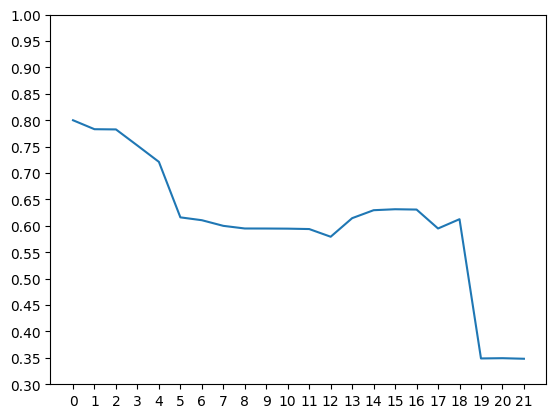

In [36]:
na_vals = [df[df["season"]==i].isna().sum().sum()/(df[df["season"]==i].shape[0]*df[df["season"]==i].shape[1]) for i in range(0,22)]
plt.xticks(range(0,22))
plt.ylim(0.3, 1)
plt.locator_params(axis='y', nbins=14)
plt.plot(na_vals)
plt.gca().ticklabel_format(axis='y', style='plain', scilimits=(0, 0))

# Feature Engineering
We decided to add several features to the dataset.
These features are:
- Result of the last match between the two contending teams
- Goal score during the last match between the two contending teams
- Average amount of goals scored in the current season
- Average amount of goals received in the current season

We believe that these features will prove useful in the training of our model as they can reveal things such as momentum and strenghts/weaknesses against certain teams.

### Result of the last match between the two contending teams

Create a string of participating teams, append them alphabetically behind each other so it is easier to slice them.

In [ ]:
df["Index"] = df.index
df["MatchTeams"] = df[["HomeTeam","AwayTeam"]].values.tolist()
df["MatchTeams"] = df["MatchTeams"].sort_values().apply(lambda x: sorted(x))

In [ ]:
df = df.assign(MatchTeams=df["MatchTeams"].apply(lambda l: "_".join(l)))

In [ ]:
df.sort_values(['MatchTeams','Date'],ascending=True).groupby('MatchTeams').shift()

Use groupby to group by same matches, create ["LastMatchIndex","LastMatchAwayGoals", "LastMatchHomeGoals"] columns with unsorted values.
First match of two teams gets empty column index as LastMatchIndex

In [ ]:
df[["LastMatchIndex","LastMatchAwayGoals", "LastMatchHomeGoals"]] = df.sort_values(['MatchTeams','Date'],ascending=True).groupby('MatchTeams').shift()[["Index","FTAG", "FTHG"]]
df.loc[np.isnan(df["LastMatchIndex"]), "LastMatchIndex"] = len(df.index)-1
df.loc[len(df.index)] = [np.nan for _ in range(df.shape[1])]
df.loc[len(df.index)-1]
df["LastMatchIndex"] = df["LastMatchIndex"].replace(np.nan, len(df.index)-1)

df["LastMatchIndex"].fillna(len(df.index)-1)

In [ ]:
arr = df["LastMatchIndex"]

Switch LastMatchHomeGoals and LastMatchAwayGoals if they do not correspond to the teams accordingly, calculate who won the match

In [ ]:
df["SameHomeTeam"] = (df.iloc[arr]["HomeTeam"].values == df["HomeTeam"].values)
df.loc[df["SameHomeTeam"],['LastMatchHomeGoals','LastMatchAwayGoals']] = df.loc[df["SameHomeTeam"],['LastMatchHomeGoals','LastMatchAwayGoals']].values
df["LastMatchAwayWin"] = (df["LastMatchAwayGoals"] > df["LastMatchHomeGoals"]).astype(int)
df["LastMatchHomeWin"] = (df["LastMatchAwayGoals"] < df["LastMatchHomeGoals"]).astype(int)
df["LastMatchDraw"] = (df["LastMatchAwayGoals"] == df["LastMatchHomeGoals"]).astype(int)

In [ ]:
df[df["MatchTeams"] == "Chelsea_Liverpool"][["Date","FTHG", "FTAG","LastMatchHomeGoals", "LastMatchAwayGoals", "LastMatchHomeWin","LastMatchAwayWin", "LastMatchDraw" ]]
df.drop(["SameHomeTeam", "LastMatchIndex", "Index"], axis=1)

In [ ]:
df["BbAH"].isna().sum()

# TODO Average amount of goals scored/received in the current season

We will add 4 columns - HomeTeamAvgScored, AwayTeamAvgScored, HomeTeamAvgReceived, AwayTeamAvgReceived

